In [1]:
from construct import *

format_word = Struct(
    "daq_major" / Byte,
    "daq_minor" / Byte,
    "data_format_major" / Byte,
    "data_format_minor" / Byte
)

two_word_file_header = Struct(
    "endian_indicator" / Int32ul,
    "data_format" / format_word
)

detector_hdr = Struct(
    "header_number" / Int32ul,
    "config_record_len" / Int32ul,
    "repeat_value" / Computed(
        lambda this: (this.config_record_len // 72) + (this.config_record_len // 144)
    )
)

charge_config_header = Struct(
    "charge_config_len" / Int32ul,
    "detector_code" / Int32sl,
    "tower_number" / Int32sl,
    "channel_post_amp" / Int32sl,
    "channel_bias" / Int32sl,
    "rtf_offset" / Int32sl,
    "delta_t" / Int32sl,
    "trigger_time" / Int32sl,
    "trace_len" / Int32sl
)

phonon_config_header = Struct(
    "phonon_config_len" / Int32ul,
    "detector_code" / Int32sl,
    "tower_number" / Int32sl,
    "post_amp_gain" / Int32sl,
    "qet_bias" / Int32sl,
    "squid_bias" / Int32sl,
    "squid_lockpoint" / Int32sl,
    "rtf_offset" / Int32sl,
    "variable_gain" / Int32sl,
    "delta_t" / Int32sl,
    "trigger_time" / Int32sl,
    "trace_len" / Int32sl
)

header_list = Struct(
    "header_number" / Int32ul,
    "charge_config" / If(
        lambda this: this.header_number == 0x10002,
        charge_config_header
    ),
    "phonon_config" / If(
        lambda this: this.header_number == 0x10001,
        phonon_config_header
    )
)

event_header = Struct(
    "event_header_word" / Int32ul,
    "event_size" / Int32ul,
    "event_identifier" / Computed(
        lambda this: (this.event_header_word >> 16) & 0xFFFF
    ),
    # 0x0: Raw, 0x1: Processed, 0x2: Monte Carlo
    "event_class" / Computed(
        lambda this: (this.event_header_word >> 8) & 0xF
    ),
    # 0x0: Per Trigger, 0x1: Occasional, 0x2: Begin File Series, 0x3: Begin File
    # 0x4: End File, 0x5: End File Series, 0x6: Per Trigger w/ Detectors that Cross Threshold
    "event_category" / Computed(
        lambda this: (this.event_header_word >> 12) & 0xF
    ),
    # 0x0: Wimp Search, 0x1: 60Co Calibration, 0x2: 60Co Low Energy Calibration,
    # 0x3: Neutron Calibration, 0x4: Random Triggers, 0x5: Pulse Triggers
    # 0x6: Test, 0x7: Data Monitering Event, 0x8: 137Cs Calibration
    "event_type" / Computed(
        lambda this: (this.event_header_word & 0xFF)
    )
)

administrative_record = Struct(
    "admin_header" / Int32ul,
    "admin_len" / Int32ul,
    "series_number_1" / Int32ul,
    "series_number_2" / Int32ul,
    "event_number_in_series" / Int32ul,
    "seconds_from_epoch" / Int32ul,
    # Epoch defined as Jan 1st 1904 for SUF (MAC Artifact)
    # Epoch defined as Jan 1st 1970 for Soudan
    "time_from_last_event" / Int32ul,
    "live_time_from_last_event" / Int32ul
)

trace_record = Struct(
    "trace_header" / Int32ul,
    "trace_len" / Int32ul,
    "trace_bookkeeping_header" / Int32ul,
    "bookkeeping_len" / Int32ul,
    "digitizer_base_address" / Int32ul,
    "digitizer_channel" / Int32ul,
    "detector_code" / Int32ul,
    "timebase_header" / Int32ul,
    "timebase_len" / Int32ul,
    "t0_in_ns" / Int32ul,
    "delta_t_ns" / Int32ul,
    "num_of_points" / Int32ul,
    "second_trace_header" / Int32ul,
    "num_samples" / Int32ul
    # Should be a power of two (1024, 2048, etc)
)

data_sample = Struct(
    "data_selection" / Int32ul,
    "sample_a" / Computed(
        lambda this: (this.data_selection >> 16) & 0xFFFF
    ),
    "sample_b" / Computed(
        lambda this: (this.data_selection & 0xFFFF)
    )
)


trace_data = Struct(
    "trace_rcrds" / trace_record,
    "sample_data" / Array(
        this.trace_rcrds.num_samples // 2,
        data_sample
    )
)

soudan_history_buffer = Struct(
    "history_buffer_header" / Int32ul,
    "history_buffer_len" / Int32ul,
    "num_time_nvt" / Int32ul,
    "time_nvt" / Array(
        this.num_time_nvt,
        Int32ul
    ),
    "num_veto_mask_words" / Int32ul,
    "time_n_minus_veto_mask" / Array(
        this.num_time_nvt * this.num_veto_mask_words,
        Int32ul
    ),
    "num_trigger_times" / Int32ul,
    "trigger_times" / Array(
        this.num_trigger_times,
        Int32ul
    ),
    "num_trigger_mask_words" / Int32ul,
    "trig_times_minus_trig_mask" / Array(
        this.num_trigger_times * this.num_trigger_mask_words,
        Int32ul
    )
)

trigger_record = Struct(
    "trigger_header" / Int32ul,
    "trigger_len" / Int32ul,
    "trigger_time" / Int32ul,
    "individual_trigger_masks" / Array(
        6,
        Int32ul
    )
)

tlb_trigger_mask_record = Struct(
    "tlb_mask_header" / Int32ul,
    "tlb_len" / Int32ul,
    "tower_mask" / Array(
        6,
        Int32ul
    )
)

gps_data = Struct(
    "tlb_mask_header" / Int32ul,
    "length" / Int32ul,
    "gps_year_day" / If(
        this.length > 0,
        Int32ul
    ),
    "gps_status_hour_minute_second" / If(
        this.length > 0,
        Int32ul
    ),
    "gps_microsecs_from_gps_second" / If(
        this.length > 0,
        Int32ul
    )
)

detector_trigger_threshold_data = Struct(
    "threshold_header" / Int32ul,
    "len_to_next_header" / Int32ul,
    "minimum_voltage_level" / Int32ul,
    "maximum_voltage_level" / Int32ul,
    "dynamic_range" / Int32ul,
    "tower_number" / Int32ul,
    "detector_codes" / Array(
        6,
        Int32ul
    ),
    "operations_codes" / Array(
        9,
        Int32ul
    ),
    "adc_values" / Array(
        54,
        Int32ul
    )
)

detector_trigger_rates = Struct(
    "detector_trigger_header" / Int32ul,
    "len_to_next_header" / Int32ul,
    "clocking_interval" / Int32ul,
    "tower_number" / Int32ul,
    "detector_codes" / Array(
        6,
        Int32ul
    ),
    "j_codes" / Array(
        5,
        Int32ul
    ),
    "counter_values" / Array(
        30,
        Int32ul
    )
)

veto_trigger_rates = Struct(
    "veto_trigger_header" / Int32ul,
    "len_to_next_header" / Int32ul,
    "clocking_interval" / Int32ul,
    "num_entries" / Int32ul,
    "detector_code" / Array(
        this.num_entries,
        Int32ul
    ),
    "counter_value_det_code" / Array(
        this.num_entries,
        Int32ul
    )
)


# Generalized logical record
logical_records = Struct(
    "event_hdr" / Peek(Int32ul),  # Peek to check first
    "next_section" / Struct(
        "next_header" / Peek(Int32ul),  # Peek without consuming
        "section" / Switch(
            lambda this: (
                this.next_header if ((this.next_header >> 16) != 0xA980) 
                else 0xA980  # Use 0xA980 as identifier for event_header
            ),
            {
                0xA980: event_header,
                0x00000002: administrative_record,
                0x00000011: trace_data,
                0x00000021: soudan_history_buffer,
                0x00000060: gps_data,
                0x00000080: trigger_record,
                0x00000081: tlb_trigger_mask_record,
                0x00000022: detector_trigger_rates,
                0x00000031: veto_trigger_rates,
            }
        )
    )
)

In [15]:
soudan = Struct(
    "file_hdr" / two_word_file_header,
    "detector_hdr" / detector_hdr,
    "hdrs" / Array(
        this._root.detector_hdr.repeat_value,
        header_list
    ),
    "logical_rcrds" / GreedyRange(logical_records)
)

test = Struct(
    "file_hdr" / two_word_file_header,
    "detector_hdr" / detector_hdr,
    "hdrs" / Array(
        this._root.detector_hdr.repeat_value,
        header_list
    ),
    "logical_rcrds" / Array(
        400,
        logical_records
    )
)

In [18]:
import h5py
import numpy as np

def parse_file(input_path, output_path):
    with open(input_path, 'rb') as f:
        raw_data = f.read()
        # Switch between soudan and test to different amounts of parsing
        parsed_data = test.parse(raw_data)
        #parsed_data = soudan.parse(raw_data)

    with h5py.File(output_path, 'w') as f:
        
        # Initializing header groups to fill with datasets
        file_hdr_grp = f.create_group('file_hdr')
        detector_hdr_grp = f.create_group('detector_hdr')

        # Initializing arrays for the header information
        file_hdr_word_list = []
        det_hdr_list = []

        # file_hdr and detector_hdr contain no arrays
        for file_hdr_type in parsed_data.file_hdr:
            hdr_type_grp = file_hdr_grp.create_group(f'{file_hdr_type}')
            file_hdr_word_list.append(hdr_type_grp)
            if file_hdr_type == 'data_format':
                for attr_name in ['daq_major', 'daq_minor', 'data_format_major', 'data_format_minor']:
                    if hasattr(parsed_data.file_hdr.data_format, attr_name):
                        attr_value = getattr(parsed_data.file_hdr.data_format, attr_name)
                        hdr_type_grp.create_dataset(attr_name, data=attr_value)
            elif file_hdr_type == "endian_indicator":
                hdr_type_grp.create_dataset('endian_indicator', data=parsed_data.file_hdr.endian_indicator)
        
        for det_data_type in parsed_data.detector_hdr:
            det_type_grp = detector_hdr_grp.create_group(f'{det_data_type}')
            det_hdr_list.append(det_type_grp)
            if det_data_type == 'header_number':
                det_type_grp.create_dataset('header_number', data=parsed_data.detector_hdr.header_number)
            elif det_data_type == 'config_record_len':
                det_type_grp.create_dataset('config_record_len', data=parsed_data.detector_hdr.config_record_len)
            elif det_data_type == 'repeat_value':
                det_type_grp.create_dataset('repeat_value', data=parsed_data.detector_hdr.repeat_value)


        # hdrs contains an array of charge and phonon headers
        hdrs_grp           = f.create_group('hdrs')
        charge_config_grp  = hdrs_grp.create_group('charge_config')
        phonon_config_grp  = hdrs_grp.create_group('phonon_config')
        hdrs_array         = []
        charge_config_list = []
        phonon_config_list = []

        # Create groups for each header and populate them with relevant datasets
        for i, header in enumerate(parsed_data.hdrs):
            # Collecting charge_config data
            if header.header_number == 0x10002:
                # HDF5 groups require unique names if at same level of structure
                charge_config_hdr_grp = charge_config_grp.create_group(f'charge_config_{i}')
                charge_config_list.append(charge_config_hdr_grp)
                hdrs_array.append(charge_config_hdr_grp)
                for attr_name in ['charge_config_len', 'detector_code', 'tower_number',
                                  'channel_post_amp', 'rtf_offset', 'delta_t', 'trigger_time',
                                  'trace_len']:
                    if hasattr(header.charge_config, attr_name):
                        attr_value = getattr(header.charge_config, attr_name)
                        charge_config_hdr_grp.create_dataset(attr_name, data=attr_value)
                
            # Collecting phonon_config data
            elif header.header_number == 0x10001:
                phonon_config_hdr_grp = phonon_config_grp.create_group(f'phonon_config_{i}')
                phonon_config_list.append(header)
                hdrs_array.append(phonon_config_hdr_grp)
                for attr_name in ['phonon_config_len', 'detector_code', 'tower_number',
                                  'post_amp_gain', 'qet_bias', 'squid_bias', 'squid_lockpoint',
                                  'rtf_offset', 'variable_gain', 'delta_t', 'trigger_time', 'trace_len']:
                    if hasattr(header.phonon_config, attr_name):
                        attr_value = getattr(header.phonon_config, attr_name)
                        phonon_config_hdr_grp.create_dataset(attr_name, data=attr_value)
        
        # Dictionary for creating groups
        logical_record_options = {
            0xA980: "event_header",
            0x00000002: "admin_rcrd",
            0x00000011: "trace_data",
            0x00000021: "soudan_history_buffer",
            0x00000060: "gps_data",
            0x00000080: "trigger_rcrd",
            0x00000081: "tlb_trigger_mask_rcrd",
            0x00000022: "detector_trigger_rates",
            0x00000031: "veto_trigger_rates",
        }

        # Creating groups that can hold each event's records
        logical_rcrd_grp       = f.create_group('logical_rcrds')
        phonon_pulse_grp       = logical_rcrd_grp.create_group('phonon_pulse')
        charge_pulse_grp       = logical_rcrd_grp.create_group('charge_pulse')

        # Initializing arrays to store the created groups of logical_rcrd data
        logical_rcrd_array       = []
        event_hdr_array          = []
        admin_rcrd_array         = []
        trigger_rcrd_array       = []
        tlb_trig_mask_rcrd_array = []
        gps_data_array           = []
        trace_data_array         = []
        soudan_buffer_array      = []
        detector_trig_array      = []
        veto_trig_array          = []

        # Initializing arrays for storing trace_data data samples
        phonon_pulse_array       = []
        charge_pulse_array       = []
        veto_array               = []
        error_array              = []

        # Counters for group naming iteration
        logic_count    = 0
        event_count    = 0
        admin_count    = 0
        trigger_count  = 0
        tlb_count      = 0
        gps_count      = 0
        trace_count    = 0
        charge_count   = 0
        phonon_count   = 0
        error_count    = 0
        soudan_count   = 0
        detector_count = 0
        veto_count     = 0

        # Using to find the unique information related to these groups
        trace_set = set()
        detector_type_set = set()
        channel_number_set = set()
        error_set = set()
        veto_set = set()

        # Loop through all of the Structs in logical_rcrds
        logical_group_i = logical_rcrd_grp.create_group(f'logical_rcrd_group_{logic_count}')
        for i, record_option in enumerate(parsed_data.logical_rcrds):
            # Handle event headers separately
            logic_count += 1
            if (record_option.next_section.next_header >> 16) == 0xA980:
                # Storing event_hdr data
                events = []
                # Loop through attributes of event_hdr and store them in event_group_i
                event_group_i = logical_group_i.create_group(f'event_group_{event_count}')
                event_count += 1
                for attr_name in ['event_header_word', 'event_size', 'event_identifier',
                                'event_class', 'event_category', 'event_type']:
                    if hasattr(record_option.next_section.section, attr_name):
                        attr_value = getattr(record_option.next_section.section, attr_name)
                        event_data = event_group_i.create_dataset(attr_name, data=attr_value)
                        events.append(event_data)
                event_hdr_array.append(events)
            
            # Iterate through the options in logical_rcrds using the type dictionary
            for value, type in logical_record_options.items():
                if record_option.next_section.next_header == value:
                    if type == 'admin_rcrd':
                        # Store admin_rcrd data in an array
                        admins = []
                        admin_group_i = logical_group_i.create_group(f'{type}_group_{admin_count}')
                        admin_count += 1
                        for attr_name in ['admin_header', 'admin_len', 'series_number_1', 'series_number_2',
                                        'event_number_in_series', 'seconds_from_epoch', 'time_from_last_event',
                                        'live_time_from_last_event']:
                            if hasattr(record_option.next_section.section, attr_name):
                                attr_value = getattr(record_option.next_section.section, attr_name)
                                admin_data = admin_group_i.create_dataset(attr_name, data=attr_value)
                                admins.append(admin_data)
                        # Store each admin_rcrd data array in higher level array
                        admin_rcrd_array.append(admins)
                
                    if type == 'trigger_rcrd':
                        # Store trigger_rcrd data in an array
                        triggers = []
                        trigger_group_i = logical_group_i.create_group(f'{type}_group_{trigger_count}')
                        trigger_count += 1
                        for attr_name in ['trigger_header', 'trigger_len', 'trigger_time', 'individual_trigger_masks']:
                            if hasattr(record_option.next_section.section, attr_name):
                                attr_value = getattr(record_option.next_section.section, attr_name)
                                trigger_data = trigger_group_i.create_dataset(attr_name, data=attr_value)
                                triggers.append(trigger_data)
                        # Store each trigger_rcrd array in higher level array
                        trigger_rcrd_array.append(triggers)

                    if  type == 'tlb_trigger_mask_rcrd':
                        # Store tlb_trigger_mask_rcrd data in an array
                        tlb_trig_mask = []
                        tlb_trig_group_i = logical_group_i.create_group(f'{type}_group_{tlb_count}')
                        tlb_count += 1
                        for attr_name in ['tlb_mask_header', 'tlb_len', 'tower_mask']:
                            if hasattr(record_option.next_section.section, attr_name):
                                attr_value = getattr(record_option.next_section.section, attr_name)
                                tlb_trig_data = tlb_trig_group_i.create_dataset(attr_name, data=attr_value)
                                tlb_trig_mask.append(tlb_trig_data)
                        # Store each array in higher level array
                        tlb_trig_mask_rcrd_array.append(tlb_trig_mask)

                    if type == 'gps_data':
                        # Storing gps_data in array
                        gps = []
                        # Loop through attributes of gps_data and store them in gps_data_group_i
                        gps_data_group_i = logical_group_i.create_group(f'{type}_group_{gps_count}')
                        gps_count += 1
                        # If length = 0, only tlb_mask_header and length have values
                        if record_option.next_section.section.length == 0:
                            for attr_name in ['tlb_mask_header', 'length']:
                                if hasattr(record_option.next_section.section, attr_name):
                                    attr_value = getattr(record_option.next_section.section, attr_name)
                                    gps_dataset = gps_data_group_i.create_dataset(attr_name, data=attr_value)
                                    gps.append(gps_dataset)
                        else:
                            for attr_name in ['tlb_mask_header', 'length', 'gps_year_day', 'gps_status_hour_minute',
                                            'gps_microsecs_from_gps_second']:
                                if hasattr(record_option.next_section.section, attr_name):
                                    attr_value = getattr(record_option.next_section.section, attr_name)
                                    gps_dataset = gps_data_group_i.create_dataset(attr_name, data=attr_value)
                                    gps.append(gps_dataset)
                        # Store gps array in higher level array
                        gps_data_array.append(gps)

                    # trace_data contains the actual data samples taken by the detector
                    # As well as the header information describing the events and detectors
                    if type == "trace_data":
                        #print(record_option.next_section.section)
                        if record_option.next_section.section.trace_rcrds:
                            trace_record_group_i = logical_group_i.create_group(f'{type}_group_{trace_count}')
                            trace_count += 1
                            # Store trace_rcrd data in an array
                            trace_rcrd = []
                            for attr_name in ['trace_header', 'trace_len', 'trace_bookkeeping_header', 'bookkeeping_len',
                                  'digitizer_base_address', 'digitizer_channel', 'detector_code', 'timebase_header',
                                  'timebase_len', 't0_in_ns', 'delta_t_ns', 'num_of_points', 'second_trace_header',
                                  'num_samples']:
                                if hasattr(record_option.next_section.section.trace_rcrds, attr_name):
                                    attr_value = getattr(record_option.next_section.section.trace_rcrds, attr_name)
                                    trace_rcrd_dataset = trace_record_group_i.create_dataset(attr_name, data=attr_value)
                                    trace_rcrd.append(trace_rcrd_dataset)
                            # Store each trace_rcrd array in higher level array
                            trace_data_array.append(trace_rcrd)

                        if record_option.next_section.section.sample_data:
                            # Store data samples in trace array          
                            trace = []
                            for data in record_option.next_section.section.sample_data:
                                trace.append(data.sample_a)
                                trace.append(data.sample_b)
                        
                        # Which array to store the trace array in depends on the detector type
                        detector_code = record_option.next_section.section.trace_rcrds.detector_code
                        # Handling single digit detector types:
                        if len(str(detector_code)) == 8:
                            detector_type = int(str(detector_code)[:2])
                        else:
                            detector_type = int(str(detector_code)[:1])
                        detector_number = int(str(detector_code)[-6:-3])
                        channel_number = int(str(detector_code)[-3:])

                        # Inspecting detector codes for detector_types not described in documentation
                        #if detector_type in [91, 90]:
                        #    print(detector_code)

                        # Finding unique values for detector type
                        detector_type_set.add(detector_type)
                        channel_number_set.add(channel_number)
                        trace_set.add(len(trace))
                        # Use detector types to sort data into charge and phonon groups
                        if detector_type in [1, 2, 4, 5, 6]: # BLIP, FLIP/ZIP/mZIP/ENDCAP (class I)
                            if channel_number in [0, 1]:
                                charge_pulse_array.append(trace)
                                charge_pulse_grp.create_dataset(f"charge_{charge_count}", data=trace)
                                charge_count += 1
                            else:
                                phonon_pulse_array.append(trace)
                                phonon_pulse_grp.create_dataset(f"phonon_{phonon_count}", data=trace)
                                phonon_count += 1
                        elif detector_type == 3:
                            veto_array.append(trace)
                            veto_set.add(len(trace))
                        elif detector_type == 7: # ENDCAP (class II)
                            if channel_number == 0:
                                charge_pulse_array.append(trace)
                                charge_pulse_grp.create_dataset(f"charge_{charge_count}", data=trace)
                                charge_count += 1
                            else:
                                phonon_pulse_array.append(trace)
                                phonon_pulse_grp.create_dataset(f"phonon_{phonon_count}", data=trace)
                                phonon_count += 1
                        elif detector_type == 10: # iZIP (class I)
                            if channel_number in [0, 1, 6, 7]:
                                charge_pulse_array.append(trace)
                                charge_pulse_grp.create_dataset(f"charge_{charge_count}", data=trace)
                                charge_count += 1
                            else:
                                phonon_pulse_array.append(trace)
                                phonon_pulse_grp.create_dataset(f"phonon_{phonon_count}", data=trace)
                                phonon_count += 1
                        elif detector_type == 11: # iZIP (class II)
                            if channel_number in [0, 1, 6, 7]:
                                charge_pulse_array.append(trace)
                                charge_pulse_grp.create_dataset(f"charge_{charge_count}", data=trace)
                                charge_count += 1
                            else:
                                phonon_pulse_array.append(trace)
                                phonon_pulse_grp.create_dataset(f"phonon_{phonon_count}", data=trace)
                                phonon_count += 1
                        else:
                            error_array.append(trace)
                            error_set.add(len(trace))
                            #print(f"Detector Code {detector_code} not consistent with documentation")

                    if type == 'soudan_history_buffer':
                        # Store soudan_history_buffer data in an array
                        soudan_buffer = []
                        soudan_buffer_group_i = logical_group_i.create_group(f'{type}_group_{soudan_count}')
                        soudan_count += 1
                        for attr_name in ['history_buffer_header', 'history_buffer_len', 'num_time_nvt', 'time_nvt',
                              'num_veto_mask_words', 'time_n_minus_veto_mask', 'num_trigger_times', 
                              'trigger_times', 'num_trigger_mask_words', 'trig_times_minus_trig_mask']:
                            if hasattr(record_option.next_section.section, attr_name):
                                attr_value = getattr(record_option.next_section.section, attr_name)
                                soudan_buffer_data = soudan_buffer_group_i.create_dataset(attr_name, data=attr_value)
                                soudan_buffer.append(soudan_buffer_data)
                        # Store each soudan_history_buffer array in higher level array
                        soudan_buffer_array.append(soudan_buffer)

                    if type == 'detector_trigger_rates':
                        # Store detector_trigger_rate data in an array
                        detector = []
                        detector_group_i = logical_group_i.create_group(f'{type}_group_{detector_count}')
                        detector_count += 1
                        for attr_name in ['detector_trigger_header', 'len_to_next_header', 'clocking_interval',
                                          'tower_number', 'detector_codes', 'j_codes', 'counter_values']:
                            if hasattr(record_option.next_section.section, attr_name):
                                attr_value = getattr(record_option.next_section.section, attr_name)
                                detector_trig_data = detector_group_i.create_dataset(attr_name, data=attr_value)
                                detector.append(detector_trig_data)
                        # Store each detector_trigger_rate in a higher level array
                        detector_trig_array.append(detector)
                        
                    if type == 'veto_trigger_rates':
                        # Store veto data in an array
                        veto = []
                        veto_group_i = logical_group_i.create_group(f'{type}_group_{veto_count}')
                        veto_count += 1
                        for attr_name in ['veto_trigger_header', 'len_to_next_header', 'clocking_interval',
                                          'num_entries', 'detector_code', 'counter_value_det_code']:
                            if hasattr(record_option.next_section.section, attr_name):
                                attr_value = getattr(record_option.next_section.section, attr_name)
                                veto_trig_data = veto_group_i.create_dataset(attr_name, data=attr_value)
                                veto.append(veto_trig_data)
                        # Store each veto array in higher level array
                        veto_trig_array.append(veto)
        logic_count +
        #for i in range(0,10):
            #print(logical_rcrd_array[i])

        #logical_rcrd_data_grp.create_dataset('dataset', data=logical_rcrd_array)


        # Print data about the arrays and their values
        print(f'Detector set:     {detector_type_set}')
        print(f'Trace length set: {trace_set}')
        print(f'Error length set: {error_set}')
        print(f'Veto length set:  {veto_set}')
        print(f'Charge array len: {len(charge_pulse_array)}')
        print(f'Phonon array len: {len(phonon_pulse_array)}')
        print(f'Veto array len:   {len(veto_array)}')
        print(f'Error array len:  {len(error_array)}')
        #return charge_pulse_array, phonon_pulse_array, veto_array, error_array


#input_path  = "../01120210_0727_F0114"
#input_path = "/data3/afisher/test/01120210_0727_F0001"
input_path = "/data3/afisher/test/01130208_1838_F0006"
output_path = "../parsed.hdf5"

# For final files, save onto novateur network:
#output_path = "/data3/afisher/test/parsed_file.hdf5"

#charge_array, phonon_array, veto_array, error_array = parse_file(input_path, output_path)
parse_file(input_path, output_path)

ValueError: Unable to synchronously create group (name already exists)

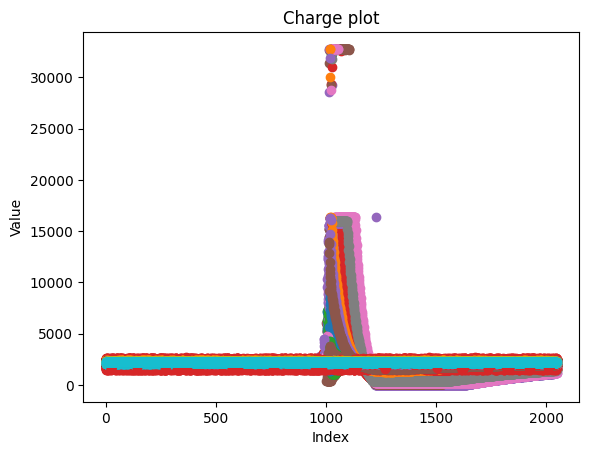

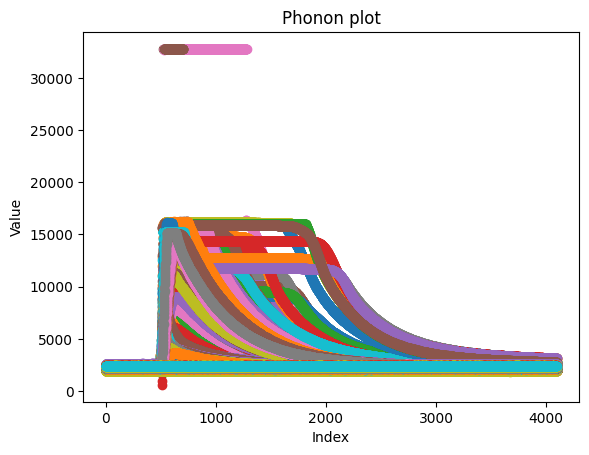

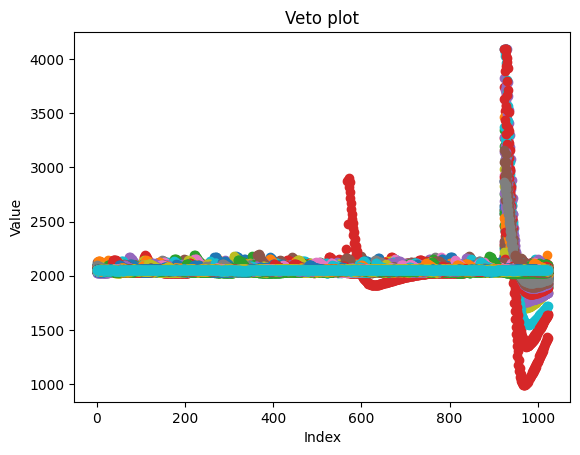

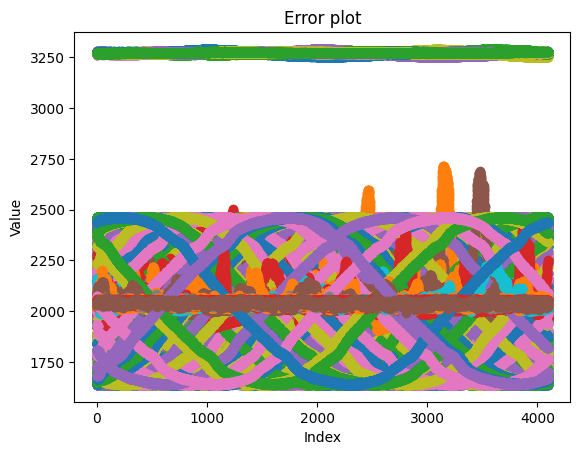

In [20]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(charge_array[0]))
for array in charge_array:
    plt.scatter(x, array)
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Charge plot")
plt.show()

x = np.arange(len(phonon_array[0]))
for array in phonon_array:
    plt.scatter(x, array)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Phonon plot')
plt.show()

x = np.arange(len(veto_array[0]))
for array in veto_array:
    plt.scatter(x, array)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Veto plot')
plt.show()

x = np.arange(len(error_array[0]))
for array in error_array:
    plt.scatter(x, array)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Error plot')
plt.show()

